<h3>Environment Setup</h3>

In [1]:
# Package installs
#pip install scikit-image
#pip install kagglehub
#pip install scikit-learn
#pip install joblib

In [2]:
# Convert to binary image
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as pltd

# Retrieve data
import kagglehub

# CCA
from skimage import measure
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Character segmentation
import numpy as np
from skimage.transform import resize

# Character recognition
import os
from sklearn.svm import SVC #Classifier
from sklearn.model_selection import cross_val_score
import joblib

In [3]:
# Download data
# path = kagglehub.dataset_download("fareselmenshawii/large-license-plate-dataset")
# print("Path to dataset files:", path)

In [4]:
# Import example image in both color and grayscale
image_path = 'images/test/1ca1155083156d72.jpg'
#Easy: 'images/test/1ca1155083156d72.jpg'
#Medium: 'images/test/a52079c6cc4050cd.jpg'
#Hard: 'images/test/f5c2a80a21ddb78c.jpg' 

example_image_gray = imread(image_path, as_gray=True)
example_image_color = imread(image_path)

# Directory for character recognition training data
training_dataset_dir = 'images/characters/train20X20'

# Directory for importing/exporting model
model_dir = 'models/svc.pk1'

<h3>Convert to binary image</h3>
<h6><a href="https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_thresholding.html">More on thresholding</a></h6>

Threshold value: 0.501953125


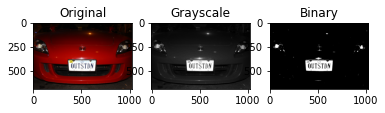

In [5]:
# Create figure with subplots for images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Show original image (color version)
ax1.imshow(example_image_color)
ax1.set_title("Original")

# Show grayscale version of image
ax2.imshow(example_image_gray, cmap="gray")
ax2.set_title("Grayscale")

# Define threshold for maximizing variance
threshold_value = threshold_otsu(example_image_gray)
print("Threshold value:" ,threshold_value)

# Show binary (thresholded) version of image
binary_image = example_image_gray > threshold_value
ax3.imshow(binary_image, cmap="gray")
ax3.set_title("Binary")

plt.show()

<h3>Label regions and draw borders</h3>

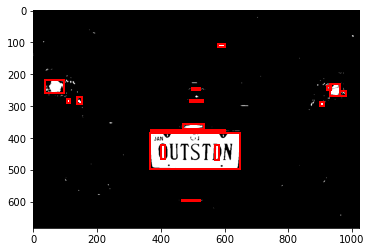

In [6]:
# Label connected regions using skimage.measure
labeled_image = measure.label(binary_image)

# Create figure
fig, (ax1) = plt.subplots(1)
ax1.imshow(binary_image, cmap="gray")

# Add red lines to visually highlight connected regions
for region in regionprops(labeled_image):
    # Exclude small regions
    if region.area < 50:
        continue
    
    # Separate box dimensions into variables
    minRow, minCol, maxRow, maxCol = region.bbox
    # Create rectangle shape given region dimensions
    rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
    # Add to figure
    ax1.add_patch(rectBorder)

plt.show()

<h3>Add region constraints to filter for plates</h3>

<h4>Limiting Properties</h4>
<ol>
    <li>Rectangular in shape</li>
    <li>Width > Height</li>
    <li>Plate width is 15-40% of the relative width</li>
    <li>Plate height is 8-20% of the relative height</li>
</ol>

In [7]:
# Constraint variables
MIN_REL_HEIGHT = 0.06
MAX_REL_HEIGHT = 0.20
MIN_REL_WIDTH = 0.15
MAX_REL_WIDTH = 0.40

# Label connected regions using skimage.measure
labeled_image = measure.label(binary_image)

img_height = labeled_image.shape[0]
img_width = labeled_image.shape[1]

min_width = MIN_REL_WIDTH * img_width
max_width = MAX_REL_WIDTH * img_width
min_height = MIN_REL_HEIGHT * img_height
max_height = MAX_REL_HEIGHT * img_height

plate_dimensions = min_height, max_height, min_width, max_width

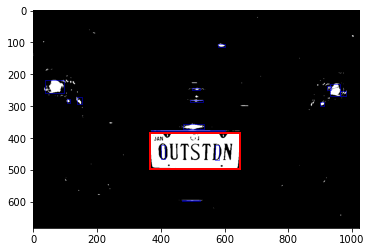

In [21]:
plate_like_objects = []
plate_object_coords = []


# Create figure
fig, (ax1) = plt.subplots(1)
ax1.imshow(binary_image, cmap="gray")

# Add red lines to visually highlight connected regions
for region in regionprops(labeled_image):
    # Exclude small regions
    if region.area < 50:
        continue
    
    # Separate box dimensions into variables
    minRow, minCol, maxRow, maxCol = region.bbox
    region_height = maxRow - minRow
    region_width = maxCol - minCol
    
    # Filter with dimension constraints for possible matches
    if (
        region_height >= min_height and region_height <= max_height
        and region_width >= min_width and region_width <= max_width
        and region_width > region_height
       ):
        plate_like_objects.append(
            binary_image[minRow:maxRow, minCol:maxCol]
        )
        plate_object_coords.append((minRow, minCol, maxRow, maxCol))
    
    
        # Create rectangle shape given region dimensions
        rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False)
        # Add to figure
        ax1.add_patch(rectBorder)
    # Distinguish non-candidate regions
    else:
        # Create rectangle shape given region dimensions
        rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="blue", linewidth=0.5, fill=False)
        # Add to figure
        ax1.add_patch(rectBorder)
    
plt.show()


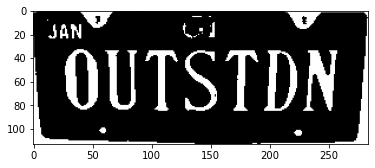

In [22]:
# Get license plate object
license_plate = np.invert(plate_like_objects[0])
# Apply labels
labeled_plate = measure.label(license_plate)

# Show license plate
fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

plt.show()

<h3>Add region constraints to filter for characters</h3>

<h4>Limiting Properties</h4>
<ol>
    <li>Character is 5-15% of the LP's width</li>
    <li>Character is 20-60% of the LP's height</li>
</ol>

In [10]:
# Define constraints
MIN_REL_LP_HEIGHT = 0.20
MAX_REL_LP_HEIGHT = 0.60
MIN_REL_LP_WIDTH = 0.05
MAX_REL_LP_WIDTH = 0.15

# Set width/height to variables
lp_height = license_plate.shape[0]
lp_width = license_plate.shape[1]

# Define constraint variables
min_char_height = lp_height * MIN_REL_LP_HEIGHT
max_char_height = lp_height * MAX_REL_LP_HEIGHT
min_char_width = lp_width * MIN_REL_LP_WIDTH
max_char_width = lp_width * MAX_REL_LP_WIDTH

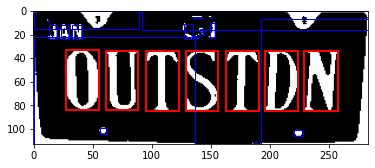

In [11]:
# Store recognized characters
characters = []
counter = 0
column_list = []

# Create image
fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

# Get regions within the license plate
for regions in regionprops(labeled_plate):
    # Define region boundary coordinates
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0
    
    # Check if region meets contraints (possible characters)
    if (
        region_height > min_char_height and
        region_height < max_char_height and
        region_width > min_char_width and
        region_width < max_char_width
    ):
        # Define region and outline
        roi = license_plate[y0:y1, x0:x1]
        rect_border = patches.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor="red", linewidth=2, fill=False)
        ax1.add_patch(rect_border)
        
        # Resize and append to array
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)
        
        column_list.append(x0)
        
    else:
        # Distinguish non-candidate regions
        rect_border = patches.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor="blue", linewidth=1, fill=False)
        ax1.add_patch(rect_border)
        
        
plt.show()


<h2>Create/train the model</h2>

In [12]:
# Define possible character matches (excludes I and letter O)
chars = [
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D',
            'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
            'U', 'V', 'W', 'X', 'Y', 'Z'
        ]

In [13]:
# Read training data to train the model. Gets each image, thresholds to binary, and stores as a flattened array
def read_training_data(training_directory):
    image_data = []
    target_data = []
    
    for each_char in chars:
        # Iterate through the 10 samples for each character
        for each in range(10):
            # Get path
            image_path = os.path.join(training_directory, each_char, each_char + '_' + str(each) + '.jpg')
            # Read image
            img_details = imread(image_path, as_gray=True)
            # Convert to binary
            binary_image = img_details < threshold_otsu(img_details)
            # Flattern into 1D array
            flattened_image = binary_image.reshape(-1)
            # Store in arrays
            image_data.append(flattened_image)
            target_data.append(each_char)
            
    return (np.array(image_data), np.array(target_data))

In [14]:
# Output cross validation accuracy for n folds
def cross_validation(model, num_folds, training_data, training_label):
    accuracy_result = cross_val_score(model, training_data, training_label, cv=num_folds)
    print("Cross validation result for " + str(num_folds) + "-fold: ")
    print(accuracy_result * 100)

In [15]:
image_data, target_data = read_training_data(training_dataset_dir)

svc_model = SVC(kernel='linear', probability=True)
svc_model.fit(image_data, target_data)

cross_validation(svc_model, 4, image_data, target_data)

print("\nExported model as:")
joblib.dump(svc_model, 'models/svc.pk1')


Cross validation result for 4-fold: 
[ 96.47058824 100.          95.29411765  98.82352941]

Exported model as:


['models/svc.pk1']

<h2>Character Prediction</h2>

In [16]:
classification_result = []

for each_character in characters:
    # Reshape to 1D array
    each_character = each_character.reshape(1, -1)
    result = svc_model.predict(each_character)
    classification_result.append(result)

# Combine characters into string
plate_chars = ''
for each_prediction in classification_result:
    plate_chars += each_prediction[0]

# Sort by x-positions stored in column_list
column_list_copy = column_list
column_list.sort()
plate_output = ''
for each in column_list:
    plate_output += plate_chars[column_list_copy.index(each)]

print(plate_output)

0UTSTDN
